In [1]:
options(warn=-1)

In [3]:
library(MatchIt)
library(dplyr)
library(reshape2)
# library(ggplot2)

library(tableone)

options(tibble.width = Inf)

#### load data

In [5]:
data <- read.csv('../data_others/ego_features.csv')

In [6]:

dat <-
  data %>%
    filter(in_degree>=2) %>%
    mutate(treatment = ifelse( weak_SD == in_degree, '1', '0'))

# Note: 'kclip diversity measure == in_degree' is equivalent to 'weak diversity measure == in_degree'

table(dat$treatment)


    0     1 
31513 54175 

In [7]:

# covariates accounted for in PSM

covs <-
c('gender_male', 'gender_na', 
  'log_in_degree',

  'log_answerCount', 'log_questionCount', 'log_articlesCount', 
  'log_columnsCount', 'log_pinsCount', 'log_favoriteCount', 

  'log_followingColumnsCount', 'log_followingFavlistsCount', 
  'log_followingQuestionCount', 'log_followingTopicCount')


# Executing a matching algorithm
data_nomiss <- dat %>%  # MatchIt does not allow missing values
  select(social_reputation_100, treatment, one_of(covs)) %>%
  na.omit()


In [8]:
dim(data_nomiss)

[1] 85688    15

#### PSM

In [9]:

# set seed for replication purpose
set.seed(1234)

# works
mod_match <- matchit(treatment ~ log_in_degree + log_answerCount + log_questionCount + 
             log_articlesCount + log_columnsCount + log_pinsCount + log_favoriteCount +
             log_followingColumnsCount + log_followingFavlistsCount + 
             log_followingQuestionCount + log_followingTopicCount +
             gender_na + gender_male,
             method = "nearest", 
             data = data_nomiss,  
             caliper = .001)

---
#### 1. get matched pairs

In [10]:

# the matched matrix
# mod_match$match.matrix


# data_nomiss[mod_match$match.matrix]
x <- cbind(data_nomiss[row.names(mod_match$match.matrix),'social_reputation_100'], data_nomiss[mod_match$match.matrix,'social_reputation_100'])
x <- as.data.frame(x)
xx <- x[!is.na(x$V2),]

# t.test(xx$V1, xx$V2)
# t.test(xx$V1, xx$V2, paired=TRUE)

# datafile of matches
matched_pairs<-as.data.frame(mod_match$match.matrix)
colnames(matched_pairs)<-c("matched_unit")

matched_pairs$matched_unit<-as.numeric(as.character(matched_pairs$matched_unit))
matched_pairs$treated_unit<-as.numeric(rownames(matched_pairs))

#now delete matches=na
matched_pairs <- matched_pairs[!is.na(matched_pairs$matched_unit),]
matched_pairs$match_num <- 1:dim(matched_pairs)[1]

# melt(data = x, id.vars = "id", measure.vars = c("blue", "red"))

matched_ids <- 
melt(data = matched_pairs, id.vars = "match_num", 
  measure.vars = c("matched_unit", "treated_unit"),
  variable.name = "matched_type", 
  value.name = "id"
  )


In [11]:
head(matched_ids)

match_num,matched_type,id
1,matched_unit,159
2,matched_unit,37374
3,matched_unit,1849
4,matched_unit,72170
5,matched_unit,13000
6,matched_unit,56478


---
#### 2. get matched data

In [12]:

data_matched <- match.data(mod_match)

data_matched$id<-as.numeric(rownames(data_matched))

data_matched <- merge(subset(matched_ids, select=c(match_num, id)), 
                      data_matched, by = c('id'))

In [13]:
dim(data_matched)

[1] 31726    19

---
#### 3. look at a table 1

In [14]:

table1<- CreateTableOne(vars=covs, strata="treatment", data=data_matched, test=FALSE)

## include standardized mean difference (SMD)
print(table1,smd=TRUE)

                                        Stratified by treatment
                                         0            1            SMD   
  n                                      15863        15863              
  gender_male (mean (sd))                 0.45 (0.50)  0.45 (0.50)  0.002
  gender_na (mean (sd))                   0.17 (0.38)  0.17 (0.38)  0.004
  log_in_degree (mean (sd))               1.01 (0.36)  1.01 (0.36)  0.002
  log_answerCount (mean (sd))             0.72 (0.60)  0.74 (0.58)  0.027
  log_questionCount (mean (sd))           0.22 (0.31)  0.23 (0.31)  0.017
  log_articlesCount (mean (sd))           0.03 (0.16)  0.03 (0.16)  0.001
  log_columnsCount (mean (sd))            0.01 (0.04)  0.01 (0.04)  0.001
  log_pinsCount (mean (sd))               0.08 (0.23)  0.08 (0.22)  0.015
  log_favoriteCount (mean (sd))           0.60 (0.44)  0.62 (0.45)  0.057
  log_followingColumnsCount (mean (sd))   0.69 (0.53)  0.72 (0.54)  0.061
  log_followingFavlistsCount (mean (sd))  0.44 (

---
#### 4. estimating treatment effects

In [15]:
y0 <- 
data_matched %>%
    arrange((match_num)) %>%
    filter(treatment==0)

y1 <- 
data_matched %>%
    arrange((match_num)) %>%
    filter(treatment==1)

In [16]:
# paired t-test
t.test(y1$social_reputation_100, y0$social_reputation_100, paired=TRUE)


	Paired t-test

data:  y1$social_reputation_100 and y0$social_reputation_100
t = 22.106, df = 15862, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 2.474083 2.955509
sample estimates:
mean of the differences 
               2.714796 


---
#### 5. PSM result visualization

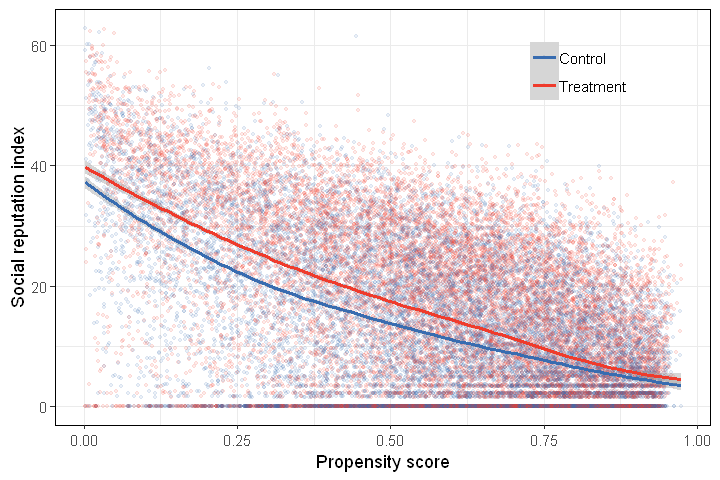

In [17]:
library(ggplot2)

options(repr.plot.width = 6, repr.plot.height = 4)

data_matched %>%
  # mutate(treatment=as.factor(treatment)) %>%
  mutate(group=ifelse(treatment==0, 'Control', 'Treatment')) %>%
  ggplot(aes(distance, social_reputation_100, color = group)) +
    # geom_point(alpha = .1, shape=1) +
    geom_point(alpha = .1, size=0.8) +
    geom_smooth(method = "loess", se = T) +
    # geom_smooth(method = "lm", se = T) +
    xlab("Propensity score") +
    ylab("Social reputation index") +
    scale_color_manual(values = c('#386cb0', '#ef3b2c')) +
    theme_bw()+
    theme(
       # legend.position="none",
       legend.position=c(0.8,0.85),
       legend.title = element_blank(),

       plot.background = element_blank(), 
       # panel.grid.major = element_blank(),
       # panel.grid.minor = element_blank(), 
       panel.border = element_rect(color='black'),
       panel.background = element_blank(),
       # axis.ticks = element_blank(),
       # legend.position=c(0.92, 0.27), legend.justification=c(1, 1), 
       # legend.title=element_blank(), 
       legend.background=element_blank(),
       # legend.text=element_text(size=12),
       # axis.text.x=element_text(angle=45, hjust=1, vjust=1)
         )